For a more visual comparison of the three different impurity criteria that we discussed in the lecture, let us plot the impurity indices for the probability range [0, 1] for class 1. Note that we will also add a scaled version of the entropy (entropy / 2) to
observe that the Gini impurity is an intermediate measure between entropy and the classification error. The code is as follows.

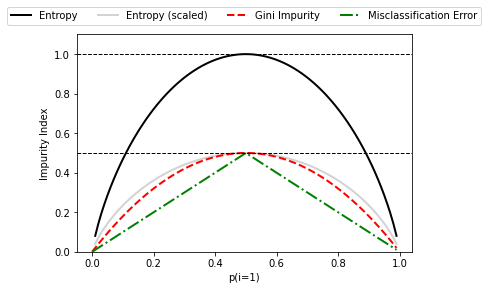

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def gini(p):
    return p * (1 - p) + (1 - p) * (1 - (1 - p))
def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))
def error(p):
    return 1 - np.max([p, 1 - p])
x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e * 0.5 if e else None for e in ent]
err = [error(i) for i in x]
fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err],
                          ['Entropy', 'Entropy (scaled)',
                           'Gini Impurity', 'Misclassification Error'],
                          ['-', '-', '--', '-.'],
                          ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=5, fancybox=True, shadow=False)
ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')
plt.show()

Let's reuse some of our old code to load the data and plot decision regions.

In [ ]:
import numpy as np
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=colors[idx], marker=markers[idx],
                    label=cl, edgecolor='black')
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='none', edgecolor='black', alpha=1.0, linewidth=1,
                    marker='o', s=100, label='test set')

Decision trees can build complex decision boundaries by dividing the feature space into rectangles. However, we have to be careful since the deeper the decision tree, the more complex the decision boundary becomes, which can easily result in overfitting. Using scikit-learn, we will now train a decision tree with a maximum depth of 4,
using Gini Impurity as a criterion for impurity. Although feature scaling may be desired for visualization purposes, note that feature scaling is not a requirement for decision tree algorithms. The code is as follows.

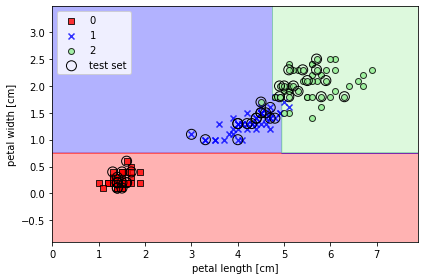

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=1)
tree.fit(X_train, y_train)
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined,
                      classifier=tree, test_idx=range(105, 150))
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

A nice feature in scikit-learn is that it allows us to export the decision tree after training. The following code will create an image of our decision tree in PNG format and donwload it from your colab files.

In [ ]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
dot_data = export_graphviz(tree, filled=True, rounded=True,
                           class_names=['Setosa',
                                        'Versicolor',
                                        'Virginica'],
                           feature_names=['petal length',
                                          'petal width'],
                           out_file=None)
graph = graph_from_dot_data(dot_data)
graph.write_png('tree.png')
from google.colab import files
files.download('tree.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Looking at the decision tree figure, we can now nicely trace back the splits that the decision tree determined from our training dataset. We started with
105 samples at the root and split them into two child nodes with 35 and 70 samples, using the petal width cut-off ≤ 0.75 cm. After the first split, we can see that the left child node is already pure and only contains samples from the Iris-setosa class
(Gini Impurity = 0). The further splits on the right are then used to separate the samples from the Iris-versicolor and Iris-virginica class. Looking at this tree, and the decision region plot of the tree, we see that the decision tree does a very good job of separating the flower classes.

#Combining multiple decision trees via random forests

Conveniently, we don't have to construct the random forest classifier from individual decision trees by ourselves because there is already an implementation in scikit-learn that we can use. After executing the preceding code, we should see the decision regions formed by the ensemble of trees in the random forest, as shown in the following figure.


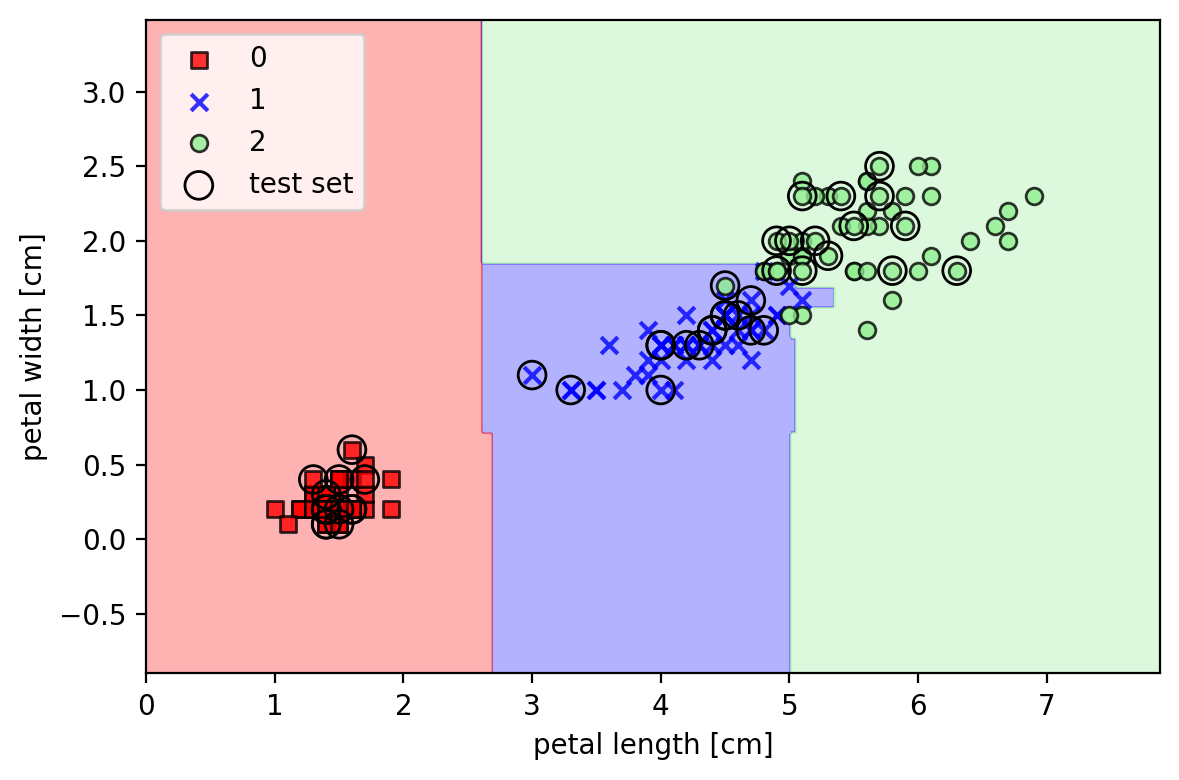

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(criterion='gini', n_estimators=25,
                                random_state=1, n_jobs=2)
forest.fit(X_train, y_train)
plot_decision_regions(X_combined, y_combined,
                      classifier=forest, test_idx=range(105, 150))
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Using the preceding code, we trained a random forest from 25 decision trees via the n_estimators parameter and used the entropy criterion as an impurity measure to split the nodes. Although we are growing a very small random forest from a very
small training dataset, we used the n_jobs parameter for demonstration purposes, which allows us to parallelize the model training using multiple threads of our google cloud instance.